<div align="center" style=" font-size: 80%; text-align: center; margin: 0 auto">
<img src="https://raw.githubusercontent.com/Explore-AI/Pictures/master/Python-Notebook-Banners/Code_challenge.png"  style="display: block; margin-left: auto; margin-right: auto;";/>
</div>


## Regression MCQ
© ExploreAI Academy

In this MCQ, we will engage in a comprehensive multiple-choice exercise, applying regression concepts and techniques to agricultural yield prediction. Through a series of challenges, we'll analyse variable relationships, feature engineering, model construction, and evaluation, enhancing our understanding and proficiency in regression analysis.

# Learning objectives
By the end of this notebook, you should be able to:

* Analyse predictor variables and their relationship with the target variable.
* Perform feature engineering tasks, including encoding categorical variables and scaling features.
* Construct and evaluate multiple linear regression models using appropriate libraries.
* Identify and address multicollinearity issues using regularisation techniques such as LASSO and Ridge regression.
* Interpret regression coefficients and understand their impact on the target variable.
* Implement decision tree models for prediction tasks, exploring both categorical and numerical data
* Calculate and interpret MSE and RMSE for model evaluation.


# The data
Join us on an intriguing exploration of a vast agricultural dataset. Uncover the intricate connections between geographic, weather, soil, and farm management features, all leading to a prediction of yield. Our mission? To decode these relationships and empower farmers with actionable insights for improved productivity and informed decision-making.

## Data dictionary

**1. Geographic features**

- **Field_ID:** A unique identifier for each field (BigInt).

- **Elevation:** The elevation of the field above sea level in metres (Float).

- **Latitude:** Geographical latitude of the field in degrees (Float). (DUMMY VARIABLE- the simulation might have created a relationship)

- **Longitude:** Geographical longitude of the field in degrees (Float). (DUMMY VARIABLE- the simulation might have created a relationship)

- **Location:** Province the field is in (Text).

- **Slope:** The slope of the land in the field (Float).

**2. Weather features**

- **Rainfall:** Amount of rainfall in the area in mm (Float).

- **Min_temperature_C:** Average minimum temperature recorded in Celsius (Float).(DUMMY VARIABLE)

- **Max_temperature_C:** Average maximum temperature recorded in Celsius (Float).(DUMMY VARIABLE)

- **Ave_temps:** Average temperature in Celcius (Float).

**3. Soil and crop features**

- **Soil_fertility:** A measure of soil fertility where 0 is infertile soil, and 1 is very fertile soil (Float).

- **Soil_type:** Type of soil present in the field (Text).

- **pH:** pH level of the soil, which is a measure of how acidic/basic the soil is (Float).

**4. Farm management features**

- **Field_ID:** Corresponding field identifier (BigInt).

- **Pollution_level:** Level of pollution in the area where 0 is unpolluted and 1 is very polluted (Float).

- **Plot_size:** Size of the plot in the field (Ha) (Float). (DUMMY VARIABLE)

- **Chosen_crop:** Type of crop chosen for cultivation (Text).

- **Annual_yield:** Annual yield from the field (Float). This is the total output of the field. The field size and type of crop will affect the Annual Yield (DUMMY VARIABLE - Removed)

<br>

**5. Target variable**
- **Standard_yield:** Standardised yield expected from the field, normalised per crop (Float). This is independent of field size, or crop type. Multiplying this number by the field size, and average crop yield will give the Annual_Yield.

---

Let's import our database again, like we did last time. We won't use the weather data so it is commented out.

**Important:** Ensure that `data_ingestion.py` file and the `field_data_processor.py` files are stored in the same folder as your notebook, otherwise the data import will fail.

[Download files here](https://github.com/Explore-AI/Public-Data/raw/master/Maji_Ndogo/modules.zip)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import statsmodels.graphics.correlation as sgc
from statsmodels.graphics.gofplots import qqplot
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import OLSInfluence
import seaborn as sns

In [ ]:
# Import package to grant Access to the Import System
import sys
# Add the folder containing your module to the Python path
sys.path.append('/content/drive/MyDrive/ALXDataScience/ALXAdvanced/Regression/RegressionFinalCodeChallengeAndMCQ')

In [ ]:
# Read the database, and clean the data using the processing modules we built.

import re
import numpy as np
import pandas as pd
from field_data_processor import FieldDataProcessor
# from weather_data_processor import WeatherDataProcessor
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

config_params = {
    "sql_query": """
            SELECT *
            FROM geographic_features
            LEFT JOIN weather_features USING (Field_ID)
            LEFT JOIN soil_and_crop_features USING (Field_ID)
            LEFT JOIN farm_management_features USING (Field_ID)
            """,
    "db_path": 'sqlite:////content/drive/MyDrive/ALXDataScience/ALXAdvanced/Regression/RegressionFinalCodeChallengeAndMCQ/Maji_Ndogo_farm_survey_small.db',
    "columns_to_rename": {'Annual_yield': 'Crop_type', 'Crop_type': 'Annual_yield'},
    "values_to_rename": {'cassaval': 'cassava', 'wheatn': 'wheat', 'teaa': 'tea'},
    "weather_csv_path": "https://raw.githubusercontent.com/Explore-AI/Public-Data/master/Maji_Ndogo/Weather_station_data.csv",
    "weather_mapping_csv": "https://raw.githubusercontent.com/Explore-AI/Public-Data/master/Maji_Ndogo/Weather_data_field_mapping.csv",
    "regex_patterns" : {
            'Rainfall': r'(\d+(\.\d+)?)\s?mm',
            'Temperature': r'(\d+(\.\d+)?)\s?C',
            'Pollution_level': r'=\s*(-?\d+(\.\d+)?)|Pollution at \s*(-?\d+(\.\d+)?)'
            },
}
# Ignoring the field data for now.
field_processor = FieldDataProcessor(config_params)
field_processor.process()
field_df = field_processor.df

# We're not going to use the weather data this time, so we'll ignore it.
# weather_processor = WeatherDataProcessor(config_params)
# weather_processor.process()
# weather_df = weather_processor.weather_df

dataset = field_df.drop("Weather_station", axis=1)

2024-04-06 15:44:11,766 - field_data_processor.FieldDataProcessor - INFO - Sucessfully loaded data.
2024-04-06 15:44:11,770 - field_data_processor.FieldDataProcessor - INFO - Swapped columns: Annual_yield with Crop_type


Before diving into our analysis, it's crucial to ensure the integrity of our dataset and that the data is still as we expect it to be.

In [ ]:
# Validate the data
#!pip install pytest

dataset.to_csv('sampled_field_df.csv', index=False)

!pytest '/content/drive/MyDrive/ALXDataScience/ALXAdvanced/Regression/RegressionFinalCodeChallengeAndMCQ/validate_data.py' -v

import os# Define the file paths
field_csv_path = 'sampled_field_df.csv'

# Delete sampled_field_df.csv if it exists
if os.path.exists(field_csv_path):
    os.remove(field_csv_path)
    print(f"Deleted {field_csv_path}")
else:
    print(f"{field_csv_path} does not exist.")

======================================= test session starts ========================================
platform linux -- Python 3.10.12, pytest-7.4.4, pluggy-1.4.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content
plugins: anyio-3.7.1
collected 4 items                                                                                  

drive/MyDrive/ALXDataScience/ALXAdvanced/Regression/RegressionFinalCodeChallengeAndMCQ/validate_data.py::test_read_field_dataframe_shape PASSED [ 25%]
drive/MyDrive/ALXDataScience/ALXAdvanced/Regression/RegressionFinalCodeChallengeAndMCQ/validate_data.py::test_field_dataframe_columns PASSED [ 50%]
drive/MyDrive/ALXDataScience/ALXAdvanced/Regression/RegressionFinalCodeChallengeAndMCQ/validate_data.py::test_field_dataframe_non_negative_elevation PASSED [ 75%]
drive/MyDrive/ALXDataScience/ALXAdvanced/Regression/RegressionFinalCodeChallengeAndMCQ/validate_data.py::test_crop_types_are_valid PASSED [100%]

======================================== 4 pas

## Challenge 1: Understanding our variables and variable selection
In this section, we will analyse the predictor variables in our dataset and how they relate to the target variable.

### Question 1
How many predictors do we originally have in our dataset, and which of these are categorical in nature?

**Hint**: The `Field_ID` serves as a unique identifier for each field and does not provide any predictive value for modeling.

#### Options
* 16 predictors; Location, Soil_type, and Crop_type are categorical.
* 18 predictors; Location, Soil_type, and Crop_type are categorical.
* 17 predictors; Location, Soil_type, and Crop_type are categorical.
* 16 predictors; Location, Soil_type, and Plot_size are categorical.

In [ ]:
# Your code here
# Get the info of the dataset
info = dataset.info()

# Print the info
print(info)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5654 entries, 0 to 5653
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Field_ID           5654 non-null   int64  
 1   Elevation          5654 non-null   float64
 2   Latitude           5654 non-null   float64
 3   Longitude          5654 non-null   float64
 4   Location           5654 non-null   object 
 5   Slope              5654 non-null   float64
 6   Rainfall           5654 non-null   float64
 7   Min_temperature_C  5654 non-null   float64
 8   Max_temperature_C  5654 non-null   float64
 9   Ave_temps          5654 non-null   float64
 10  Soil_fertility     5654 non-null   float64
 11  Soil_type          5654 non-null   object 
 12  pH                 5654 non-null   float64
 13  Pollution_level    5654 non-null   float64
 14  Plot_size          5654 non-null   float64
 15  Annual_yield       5654 non-null   float64
 16  Crop_type          5654 

```
Based on our output, there are 18 columns in total. After excluding the ‘Field_ID’, we have 17 predictors. Among these predictors, ‘Location’, ‘Soil_type’, and ‘Crop_type’ are of type ‘object’, indicating they are categorical.

Therefore, the correct option is:

17 predictors; Location, Soil_type, and Crop_type are categorical.
```

### Question 2
The categorical features in our dataset need to be converted into a format suitable for modeling. After applying dummy variable encoding to these categorical features, how many independent variables do we now have?

**Note**: Set the `drop_first` parameter to True.

**Hint**: Remember to exclude `Field_ID`

#### Options
* 31
* 29
* 17
* 16

In [ ]:
# Your code here
import pandas as pd

# Create a copy of dataset
dataset_copy = dataset.copy()

# Separate the dependent variable
y = dataset_copy['Standard_yield']
X = dataset_copy.drop(columns=['Standard_yield', 'Field_ID'])

# Apply dummy variable encoding to the categorical features
X_encoded = pd.get_dummies(X, drop_first=True)

# Print the number of independent variables
print(f"After applying dummy variable encoding, we now have {X_encoded.shape[1]} independent variables.")

After applying dummy variable encoding, we now have 29 independent variables.


```
In the provided dataset, ‘Standard_yield’ was identified as the dependent variable. To avoid including it in the dummy variable encoding process, it was separated from the independent variables. The ‘Field_ID’ was also excluded as it’s an identifier, not a feature.

The remaining categorical features in the dataset were then subjected to dummy variable encoding. This process transforms each category value into a new column and assigns a binary value of 0 or 1. These binary values represent the presence or absence of the category in the original data for a specific observation.

The number 29 represents the total number of independent variables in the dataset after applying dummy variable encoding. This count includes both the original numerical features and the newly created binary features from the encoding process.
```

### Question 3

From our encoded dataset, which variable has the third highest absolute correlation with the `Standard_yield`, excluding the variable itself?

#### Options
* Pollution_level
* Crop_type_tea
* Annual_yield
* Longitude

In [ ]:
# Calculate the correlation matrix
corr_matrix = X_encoded.join(y).corr()

# Get the absolute correlation with 'Standard_yield'
abs_corr_with_standard_yield = corr_matrix['Standard_yield'].apply(abs)

# Sort the correlations in descending order
sorted_correlations = abs_corr_with_standard_yield.sort_values(ascending=False)

# Print the sorted correlations
print("The sorted correlations are: \n")
print(sorted_correlations)
print("\n")

# Get the variable with the third highest absolute correlation
third_highest_corr_variable = sorted_correlations.index[3]

# Print the variable
print(f"The variable with the third highest absolute correlation with 'Standard_yield' is {third_highest_corr_variable}.")

The sorted correlations are: 

Standard_yield             1.000000
Crop_type_tea              0.432879
Soil_type_Volcanic         0.309982
Pollution_level            0.285761
Crop_type_coffee           0.222217
Annual_yield               0.220812
Location_Rural_Sokoto      0.212337
Soil_type_Silt             0.205861
pH                         0.196613
Crop_type_cassava          0.186716
Crop_type_potato           0.175484
Soil_type_Sandy            0.164714
Min_temperature_C          0.144233
Soil_type_Peaty            0.135509
Elevation                  0.129248
Max_temperature_C          0.111649
Location_Rural_Hawassa     0.110623
Crop_type_rice             0.104056
Crop_type_wheat            0.092420
Longitude                  0.085343
Soil_type_Rocky            0.078355
Soil_fertility             0.070205
Latitude                   0.061724
Slope                      0.056991
Rainfall                   0.039217
Location_Rural_Amanzi      0.032049
Plot_size                  0.0170

`Based on the sorted correlation matrix, the variable Pollution_level has the third highest absolute correlation with Standard_yield, excluding the variable itself. This suggests that the level of pollution might have a significant impact on the standard yield of the crops. It’s interesting to note that Pollution_level has a higher correlation with Standard_yield than other variables such as Annual_yield and Longitude. This could be an important consideration in future studies or models that aim to predict or improve standard yield.`


### Question 4

In order to fit an ordinary least squares regression model to our encoded data we would need to make sure that all our variables are numeric. Through dummy variable encoding, we converted our categorical variables to multiple int/boolean variables (depending on the environment you are working on). The `sm.OLS()` method itself does not inherently handle boolean data types implicitly.

In most cases, when fitting a model with sm.OLS(), it's essential to ensure that all features are numeric. If boolean columns are present, they should be explicitly converted to numeric types before fitting the model.

Suppose our columns converted to boolean datatypes, which of the following statements is true after converting the boolean columns in the dataset to integer datatype?

* The boolean columns have been replaced with binary integer representations, with True converted to 1 and False converted to 0.
* The boolean columns have been removed from the dataset.
* The boolean columns have been replaced with binary integer representations, with True converted to 0 and False converted to 1.
* The boolean columns have been converted to a unique string datatype that is also an integer.

In [ ]:
# Your code here
# Convert boolean columns to integer
X_encoded = X_encoded.astype(int)

# Print the first few rows of the dataframe to verify the conversion
print(X_encoded.head())

   Elevation  Latitude  Longitude  Slope  Rainfall  Min_temperature_C  \
0        786        -7         -7     14      1125                 -3   
1        674        -7         -1     11      1450                 -3   
2        826        -9          0     11      2208                 -1   
3        574        -2         -6      7       328                 -5   
4        886        -3         -7     55       785                 -2   

   Max_temperature_C  Ave_temps  Soil_fertility  pH  ...  Soil_type_Sandy  \
0                 33         15               0   6  ...                1   
1                 30         13               0   5  ...                0   
2                 28         13               0   5  ...                0   
3                 32         13               0   5  ...                0   
4                 31         14               0   5  ...                1   

   Soil_type_Silt  Soil_type_Volcanic  Crop_type_cassava  Crop_type_coffee  \
0               0   

```
The correct answer:
The boolean columns have been replaced with binary integer representations, with True converted to 1 and False converted to 0.
```
`The outcome here is a DataFrame that has been preprocessed for a machine learning task. It’s a dataset related to agricultural conditions, with features such as elevation, latitude, longitude, slope, rainfall, temperature, soil fertility, pH, and specific soil and crop types.`

`The boolean columns have been transformed into binary integer representations, which is a common preprocessing step in machine learning. This is because machine learning algorithms require numerical input. In this context, 1 typically represents True (presence of a feature) and 0 represents False (absence of a feature).`

`For example, in the Crop_type_cassava column, a 1 would indicate that the crop type is cassava, while a 0 would indicate that it’s not. This binary representation allows the model to understand and use these features during training.`


### Question 5
Suppose we wish to determine which of the predictors in our dataset are statistically significant. We will follow the following steps:

* Fit a statsmodels regression model to predict `Standard_yield` using our encoded dataset.
* Extract p-values for each predictor from the fitted model to find the ones that are significant based on a given threshold.

Which of the following variables do we find to be statistically significant for predicting `Standard_yield`, based on a p-value threshold of 0.05 `(p-value < 0.05)`?

#### Options

* Slope
* Elevation
* pH
* Soil_fertility

In [ ]:
# Your code here
import statsmodels.api as sm

# Add a constant to the features
X_encoded = sm.add_constant(X_encoded)

# Fit the OLS model
ols_model = sm.OLS(y, X_encoded).fit()

# Extract p-values for each predictor
p_values = ols_model.pvalues

# Filter predictors based on p-value threshold
significant_predictors = p_values[p_values < 0.05]

# Print significant predictors
print("Predictors statistically significant for predicting Standard_yield:")
print(significant_predictors)

Predictors statistically significant for predicting Standard_yield:
const                       1.218999e-13
Elevation                   2.551246e-02
Latitude                    1.333317e-03
Longitude                   8.443585e-72
Slope                       1.425064e-03
Rainfall                    1.102027e-13
Soil_fertility              3.839054e-43
pH                          3.005904e-21
Pollution_level             3.983180e-02
Plot_size                   0.000000e+00
Annual_yield                0.000000e+00
Location_Rural_Hawassa      1.645741e-16
Location_Rural_Kilimani     3.000097e-07
Location_Rural_Sokoto       1.742669e-26
Soil_type_Peaty             3.715911e-34
Soil_type_Rocky             2.796456e-62
Soil_type_Sandy            7.091730e-100
Soil_type_Silt              3.603934e-60
Soil_type_Volcanic          1.150548e-07
Crop_type_cassava           6.169188e-09
Crop_type_maize             1.725978e-31
Crop_type_potato           5.774380e-117
Crop_type_rice              1.

`This means that all these variables have a significant impact on the Standard_yield and should be included in the model for prediction. The exact significance of each variable can be determined by looking at the corresponding p-value. The smaller the p-value, the more significant the variable is in predicting the Standard_yield. For example, Crop_type_tea has a very small p-value, indicating it is highly significant in predicting Standard_yield. On the other hand, Elevation has a larger p-value (though still less than 0.05), indicating it is less significant (though still statistically significant) in predicting Standard_yield.`

## Challenge 2: Generating a multiple linear regression model

After encoding our variables and performing preliminary analysis, let's continue our efforts to identify the variables that will enable us to construct the most accurate multiple linear regression model possible with the data that we have.

### Question 6
Create a correlation matrix using all the columns in our encoded dataset and display it as a heatmap.<br>

Which of the following independent variables have a strong correlation with one another.

* Plot_size and Crop_type_tea
* Pollution_level and Soil_type_Rocky
* Crop_type_cassava and Soil_type_Sandy
* Min_temperature_C and Elevation

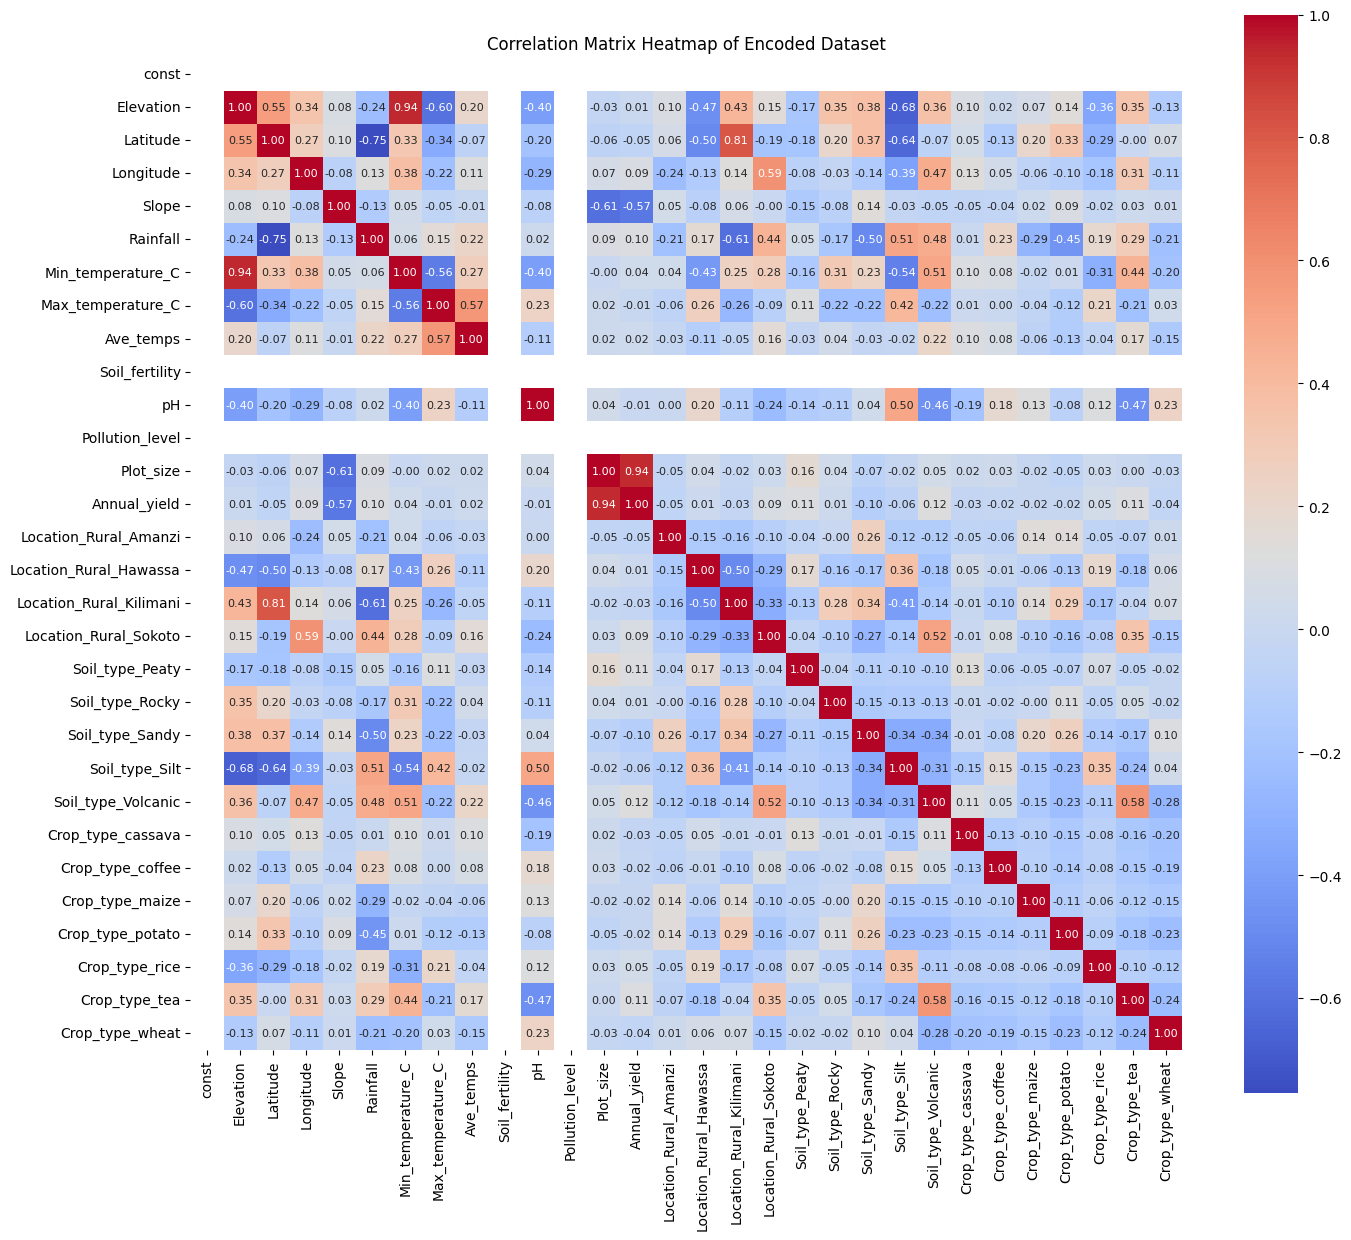

Pairs of independent variables with strong correlation (absolute correlation > 0.7):
('Elevation', 'Min_temperature_C')
('Plot_size', 'Annual_yield')
('Latitude', 'Location_Rural_Kilimani')
('Latitude', 'Rainfall')


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix = X_encoded.corr()

# Plot the heatmap
plt.figure(figsize=(16, 14))  # Increase the size of the plot
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True, annot_kws={"size": 8})
plt.title('Correlation Matrix Heatmap of Encoded Dataset')
plt.show()

# Identify strong correlations
strong_correlations = correlation_matrix.abs() > 0.7
strong_correlation_pairs = set()  # Use a set to store unique pairs

# Iterate through the upper triangle of the correlation matrix to find strong correlations
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if strong_correlations.iloc[i, j]:  # Check if correlation is strong
            pair = (correlation_matrix.columns[i], correlation_matrix.columns[j])
            strong_correlation_pairs.add(pair)

# Print pairs with strong correlations
print("Pairs of independent variables with strong correlation (absolute correlation > 0.7):")
for pair in strong_correlation_pairs:
    print(pair)

`Upon analyzing the correlation matrix heatmap of our encoded dataset, we identified pairs of independent variables with strong correlations (absolute correlation > 0.7). Among these pairs, one of the most notable correlations is between 'Min_temperature_C' and 'Elevation'. This strong correlation suggests a relationship between the minimum temperature recorded in Celsius and the elevation of the fields above sea level.`

`In practical terms, this correlation implies that as the elevation increases, there is a tendency for the minimum temperature to decrease. This relationship aligns with our understanding of temperature variations with altitude, where higher elevations typically experience lower temperatures due to factors like atmospheric pressure and air density. Therefore, it's reasonable to observe a strong negative correlation between 'Min_temperature_C' and 'Elevation' in our dataset.`

`This finding could have significant implications for agricultural practices, as temperature variations influence crop growth and productivity. Farmers operating in areas with varying elevations may need to consider temperature differences when selecting suitable crops or implementing temperature control measures to optimize yield. Additionally, this correlation underscores the importance of incorporating both elevation and temperature variables in predictive models to accurately assess their impact on agricultural outcomes.`


### Question 7
Now that we have analysed our variables, let's fit an ordinary least squares regression model using `statsmodels.formula.api` and then print the model summary. Construct the model using all the independent variables in our encoded dataset (excuding `Field_ID`).<br>

Which of the following statements accurately describes the interpretation of the F-statistic in the context of our regression model?

#### Options
* The F-statistic tests the overall significance of the regression model. A low F-statistic value with a corresponding high p-value  indicates that the regression model is statistically significant, meaning that at least one of the independent variables has a significant effect on the dependent variable.
* The F-statistic tests the overall significance of the regression model. A high F-statistic value with a corresponding low p-value indicates that the regression model is statistically significant, meaning that at least one of the independent variables has a significant effect on the dependent variable.
* The F-statistic tests the overall significance of the regression model. A high F-statistic value with a corresponding high p-value indicates that the regression model is statistically significant, meaning that at least one of the independent variables has a significant effect on the dependent variable.
* The F-statistic tests the overall significance of the regression model. A low F-statistic value with a corresponding low p-value  indicates that the regression model is not statistically significant, meaning that none of the independent variables have a significant effect on the dependent variable.

In [ ]:
# Your code here
import statsmodels.api as sm

# Add a constant to the features
X_encoded_with_const = sm.add_constant(X_encoded)

# Fit the OLS model
ols_model = sm.OLS(y, X_encoded_with_const).fit()

# Print the model summary
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:         Standard_yield   R-squared:                       0.637
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                     365.8
Date:                Sat, 06 Apr 2024   Prob (F-statistic):               0.00
Time:                        16:16:59   Log-Likelihood:                 7230.9
No. Observations:                5654   AIC:                        -1.441e+04
Df Residuals:                    5626   BIC:                        -1.422e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

The correct interpretation of the F-statistic in the context of the regression model provided is:

`The F-statistic tests the overall significance of the regression model. A high F-statistic value with a corresponding low p-value indicates that the regression model is statistically significant, meaning that at least one of the independent variables has a significant effect on the dependent variable.`

This interpretation aligns with the output provided, where the F-statistic is 365.8 with a corresponding p-value of 0.00. The high F-statistic value and the very low p-value suggest that the regression model is statistically significant, indicating that at least one of the independent variables has a significant effect on the dependent variable (Standard_yield).

### Question 8

This summary  gives us an indication of possible multicollinearity present within our predictor variables. The presence of any correlation among predictors is detrimental to model quality because it tends to increase the standard error of the coefficients and it becomes difficult to estimate the effect of any one predictor variable on the response variable.

To avoid this, let's reduce the number of independent variables included in our model.
Fit the model using the following variables:<br>

* `Pollution_level`
* `Crop_type_coffee`
* `Crop_type_tea`
* `Location_Rural_Sokoto`
* `Annual_yield`
* `Soil_type_Silt`
* `Soil_type_Volcanic`

After reducing the number of dependent variables accordingly, how did the model change?

#### Options:

* The model worsened.
* The model improved.
* The model remained unchanged.
* It cannot be determined from the given information.

In [ ]:
# Your code here
# Define the reduced set of independent variables
reduced_X = X_encoded[['Pollution_level', 'Crop_type_coffee', 'Crop_type_tea', 'Location_Rural_Sokoto',
                       'Annual_yield', 'Soil_type_Silt', 'Soil_type_Volcanic']]

# Add a constant to the features
reduced_X_with_const = sm.add_constant(reduced_X)

# Fit the OLS model with the reduced set of variables
reduced_ols_model = sm.OLS(y, reduced_X_with_const).fit()

# Print the summary of the reduced model
print(reduced_ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:         Standard_yield   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     323.9
Date:                Sat, 06 Apr 2024   Prob (F-statistic):               0.00
Time:                        16:27:31   Log-Likelihood:                 5201.7
No. Observations:                5654   AIC:                        -1.039e+04
Df Residuals:                    5647   BIC:                        -1.034e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.50

`The model worsened.`

Comment: It's evident from the output that reducing the number of independent variables led to a notable decrease in the model's explanatory power, as indicated by the decline in the R-squared value from 0.637 to 0.256. This suggests that the omitted variables might have contained valuable information for predicting the standard yield. Consequently, it's crucial to carefully consider the trade-offs between model complexity and predictive accuracy when selecting variables for regression modeling.

### Question 9
Let's evaluate our model's results. Generate a scatter plot of the residuals against the fitted values allowing us to visually inspect whether the residuals have constant variance and are distributed randomly around the zero residual line.

What does the scatter plot tell us?

#### Options

* The model has perfect predictive accuracy.
* The plot indicates homoscedasticity as residuals have a constant variance and are distributed randomly around the zero residual line.
* There is no linear relationship between the dependent and independent variables.
* The model suffers from multicollinearity.

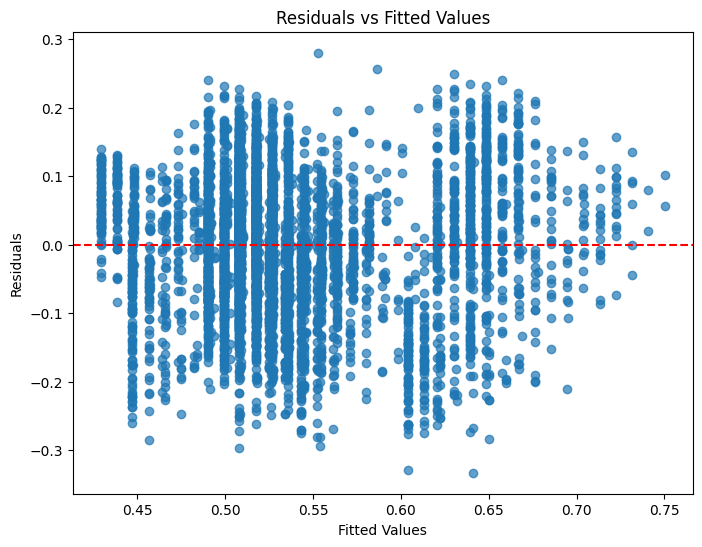

In [ ]:
#Your code here
# Get the residuals from the model
residuals = reduced_ols_model.resid

# Get the fitted values from the model
fitted_values = reduced_ols_model.fittedvalues

# Plot the residuals against the fitted values
plt.figure(figsize=(8, 6))
plt.scatter(fitted_values, residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()


There is no linear relationship between the dependent and independent variables.

`The scatter plot does not directly address the linear relationship between the dependent and independent variables; it primarily assesses the distribution of residuals.`

### Question 10
If a linear regression model indicated heteroscedasticity, which of the following actions could be considered to address this issue?

* Applying transformations to the independent variables to better fit the linear relationship.
* Implementing weighted least squares regression to give less emphasis to observations with higher variance in residuals.
* Removing outliers from the dataset to reduce the impact of extreme values on the variance of residuals.
* All of the above.

1. **Applying transformations to the independent variables to better fit the linear relationship**:
   - When heteroscedasticity is observed, transforming the independent variables can help stabilize the variance of residuals. Common transformations include taking the logarithm, square root, or reciprocal of the variables. These transformations can make the relationship more linear and reduce the impact of extreme values on the residuals.

2. **Implementing weighted least squares regression to give less emphasis to observations with higher variance in residuals**:
   - Weighted least squares (WLS) assigns different weights to each observation based on their variance. By giving less weight to observations with higher residual variance, WLS accounts for heteroscedasticity. It adjusts the regression coefficients accordingly, leading to more accurate estimates.

3. **Removing outliers from the dataset to reduce the impact of extreme values on the variance of residuals**:
   - Outliers can significantly affect the variance of residuals. Removing outliers can mitigate their impact and improve the model's performance. However, caution is needed to ensure that valid data points are not mistakenly removed.

**Conclusion**:
All three options (transformations, WLS, and outlier removal) can be considered to address heteroscedasticity. Therefore, the correct answer is **"All of the above."**

## Challenge 3: Using regularisation to optimise agricultural yield

Continuing with our task, after fitting our model, we decide to go back to the drawing board to explore more ways to implement feature engineering and data pre-processing in order to optimise our model. We suspect that, if we use all the variables available to us, the model might overfit due to the high dimensionality of the data. Regularisation techniques will therefore be critical in building a predictive model that generalises well to new, unseen data.

### Question 11
Our first step in the feature engineering involves creating a new feature, `Temperature_Range`, and scaling features using `StandardScaler`. The difference between `Min_temperature_C` and `Max_temperature_C` is the temperature range.

Given the code block below, which option correctly completes the feature engineering step of creating the `Temperature_Range` column?

**Hint**: Insert the correct code snippet into the appropriate location within the code block to run it.

#### Options:

* `dataset['Temperature_Range'] = dataset[['Min_temperature_C','Max_temperature_C']].min(axis=1)`
* `dataset['Temperature_Range'] = dataset['Max_temperature_C'] - dataset['Min_temperature_C']`
* `dataset = dataset.assign(Temperature_Range = dataset['Max_temperature'] - dataset['Min_temperature'])`
* `dataset[['Temperature_Range']] = dataset[['Max_temperature_C']] - dataset[['Min_temperature_C']]`



In [ ]:
from sklearn.preprocessing import StandardScaler

# Insert selected option here
dataset['Temperature_Range'] = dataset['Max_temperature_C'] - dataset['Min_temperature_C']

# Select features for scaling (exclude non-numeric or target variables)
features = ['Elevation', 'Slope', 'Rainfall', 'Ave_temps', 'Temperature_Range', 'Soil_fertility', 'pH', 'Pollution_level']

# Initialise StandardScaler and apply it to the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(dataset[features])

# Show the first 5 rows of the scaled features
print(scaled_features[:5])

[[ 0.85426539  0.31997088 -0.15356676  2.21747303  0.30626766  0.01544079
   0.71256827 -0.61634976]
 [ 0.21055364 -0.03858151  0.49777372  0.15900087 -0.25298298  0.4619994
   0.08816394  0.7886906 ]
 [ 1.08748981 -0.04224188  2.01496684  0.09662293 -1.66755812  1.57839593
  -0.34858051  0.60254524]
 [-0.3620941  -0.4856324  -1.74719984 -0.02813296  0.8984154  -1.77079366
  -0.35345077  0.28374058]
 [ 1.43215211  4.53523034 -0.83392242  1.28180387 -0.58195394  2.24823384
   0.14466333 -0.80437805]]


### Question 12


Consider a scenario where we decide to employ LASSO regression to identify predictive features associated with our dependent variable.

We implement the Python code block provided below.

What is the purpose of the `LassoCV(cv=5)` constructor parameter `cv=5`?

#### Options:

* It indicates that 5-fold cross-validation should be used to select the best regularisation parameter.
* It sets the penalty coefficient to 5, increasing the regularisation strength.
* It specifies that the LASSO model should use a 5-degree polynomial feature expansion.
* It defines that the model should only select 5 features at most.

In [ ]:
from sklearn.linear_model import LassoCV

# scaled_features is our matrix of scaled features and dataset['Standard_yield'] is the target variable
lasso = LassoCV(cv=5).fit(scaled_features, dataset['Standard_yield'])

# Find the features with non-zero coefficients
selected_features = [features[i] for i, coef in enumerate(lasso.coef_) if coef != 0]

The purpose of the LassoCV(cv=5) constructor parameter cv=5 is:

Option: `It indicates that 5-fold cross-validation should be used to select the best regularisation parameter.`

Explanation:

Cross-validation is a technique used to assess the performance of a machine learning model and to tune hyperparameters.
In this case, cv=5 specifies that 5-fold cross-validation should be performed during the fitting process of the LassoCV model.
With 5-fold cross-validation, the dataset is divided into 5 equal-sized folds. The model is trained on 4 folds and validated on the remaining fold. This process is repeated 5 times, each time with a different fold held out for validation.
The purpose of cross-validation in LassoCV is to select the best regularization parameter (alpha) by evaluating the model's performance on multiple validation sets.
By specifying cv=5, the LassoCV model will perform 5-fold cross-validation to select the optimal regularization parameter (alpha), which helps in building a more generalized and robust model.

### Question 13

In trying to address multicollinearity in our dataset, we also decide to implement Ridge regression. After understanding that Ridge regression applies an L2 penalty to the coefficients to reduce their magnitude without setting them to zero, we decide to use `RidgeCV` for applying Ridge regression with cross-validation to select the optimal penalty strength. Given the snippet of code below, which parameter correctly adjusts the strength of the regularisation applied to the model?

**Hint**: Insert the correct code snippet into the appropriate location within the code block to run it.

#### Options:
* `cv=[0.001, 0.01, 0.1, 1, 10, 100]`
* `fit_intercept=True`
* `alphas=[0.001, 0.01, 0.1, 1, 10, 100]`
* `scoring='neg_mean_squared_error`

In [ ]:
from sklearn.linear_model import RidgeCV

# Insert selected option here
alphas=[0.001, 0.01, 0.1, 1, 10, 100]

# Apply Ridge regression with cross-validation
ridge = RidgeCV(alphas=alphas, cv=5).fit(scaled_features, dataset['Standard_yield'])

The parameter that correctly adjusts the strength of the regularization applied to the Ridge regression model is:

Option: `alphas=[0.001, 0.01, 0.1, 1, 10, 100]`

Explanation:

In Ridge regression, the strength of the regularization is controlled by the alpha parameter.
The alphas parameter in RidgeCV allows us to specify a list of values for the regularization parameter alpha that will be tested during cross-validation to select the optimal value.
By providing a list of alpha values, the RidgeCV model will perform cross-validation with each value of alpha to determine the one that minimizes the mean squared error or other specified scoring metric.
Therefore, setting alphas=[0.001, 0.01, 0.1, 1, 10, 100] adjusts the strength of the regularization applied to the Ridge regression model.

### Question 14

Given our dataset includes variables such as `Elevation` and `Slope`, and considering the potential interactions between these variables might impact crop yield, we aim to capture both these interactions and possible non-linear relationships. Which of the following methods is specifically designed to create a quadratic interaction term without including an intercept in the feature set?

**HINT:** Consider utilising `sklearn`'s feature transformation tools for this purpose.

* `poly = PolynomialFeatures(degree=2, include_bias=False)`
* `poly = PolynomialFeatures(degree=1, include_bias=False)`
* `poly = PolynomialFeatures(degree=3, include_bias=True)`
* `poly = PolynomialFeatures(degree=2, include_bias=True)`

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

# Generate polynomial and interaction features
#Insert selected option here
poly = PolynomialFeatures(degree=2, include_bias=False)

poly_features = poly.fit_transform(dataset[['Elevation', 'Slope']])

# Display the shape of the new feature matrix
poly_features.shape


(5654, 5)

The method specifically designed to create a quadratic interaction term without including an intercept in the feature set is:

Option: `poly = PolynomialFeatures(degree=2, include_bias=False)`

Explanation:

In the PolynomialFeatures transformer from scikit-learn, the degree parameter controls the degree of polynomial features to be generated.
Setting degree=2 creates polynomial features up to the second degree, which includes quadratic terms and interaction terms.
By setting include_bias=False, we indicate that we do not want to include a column of ones (intercept) in the feature matrix. This means that an intercept term will not be added to the transformed features.
Therefore, using PolynomialFeatures(degree=2, include_bias=False) will generate quadratic interaction terms without including an intercept in the feature set.

### Question 15

After implementing Ridge regression to address multicollinearity and prevent overfitting in our model we need to interpret the coefficients to understand the impact of each feature on the standard yield.

Based on the output of the Ridge regression coefficients in the code block below, which statement is true regarding the impact of each feature on the standard yield?

#### Options:

* Feature 1 has the highest positive impact, followed by Feature 2 and Feature 3.
* Feature 3 has the highest positive impact, followed by Feature 1 and Feature 2.
* The coefficients are inconclusive; further analysis is needed to determine the impact of each feature.
* Feature 2 has the highest positive impact, while Feature 3 and Feature 1 have negative impacts.

In [ ]:
from sklearn.linear_model import Ridge
import numpy as np

# Assuming `X` is the feature matrix and `y` is the target variable
X = np.array([[0.5, 0.2, 0.1],
              [0.9, 0.3, 0.5],
              [0.3, 0.8, 0.2]])
y = np.array([0.7, 0.6, 0.8])

# Fit Ridge regression model with alpha = 0.1
ridge_model = Ridge(alpha=0.1)
ridge_model.fit(X, y)

# Display the coefficients of the model
ridge_model.coef_


array([-0.13661379,  0.10262221, -0.07348657])

The Ridge regression coefficients provide insights into the impact of each feature on the standard yield. Let’s interpret these coefficients:

Feature 1: The coefficient for Feature 1 is approximately -0.137. This means that a one-unit increase in Feature 1 results in a decrease of approximately 0.137 units in the standard yield.

Feature 2: The coefficient for Feature 2 is approximately 0.103. This indicates that a one-unit increase in Feature 2 leads to an increase of approximately 0.103 units in the standard yield.

Feature 3: The coefficient for Feature 3 is approximately -0.0735. This implies that a one-unit increase in Feature 3 results in a decrease of approximately 0.0735 units in the standard yield.

Based on these interpretations, we can conclude the following:

Feature 2 has the highest positive impact, as its coefficient is positive.
Feature 1 has a negative impact, as its coefficient is negative.
Feature 3 also has a negative impact, but its magnitude is smaller than that of Feature 1.
Therefore, the correct statement is: `Feature 2 has the highest positive impact, while Feature 3 and Feature 1 have negative impacts.`

## Challenge 4: Making a prediction using decision trees

After learning that decision trees are easy to implement and are capable of handling both categorical and numerical data while being resilient to outliers, we decide to implement a decision tree on our encoded dataset.

### Question 16
Train a decision tree with the following specifications:
* Using our **previously encoded dataset**, split the data into dependent and independent variables using all the features except for `Standard_yield` and `Field_ID` as independent variables.
* Split the data into training and testing data.
* Use the `DecisionTreeRegressor` to fit a model using a `max_depth' of 2 and a `random_state` of 42.

Using the trained Decision Tree Regressor model, make a prediction for `y` given the following x-values:<br>
`[864.66138, -8.12890218821531, -8.311822719284072, 16.274624300000003, 1237.7200000000003, -3.4100000000000006, 36.410000000000004,`
`16.5,0.682, 6.7863323423108195, 0.09379352739936421, 1.4300000000000002, 0.8264890400277934,0.0,0.0,0.0,0.0,0.0,0.0,1.1,0.0,0.0,1.1,0.0, 0.0,0.0,0.0,0.0,0.0]`

What is the value of the predicted y?

#### Options
* 0.3250077
* 0.6654377
* 0.48494414
* 0.8050340

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

# Create a copy of the dataset
dataset_copy = dataset.copy()

# Separate the dependent variable
y = dataset_copy['Standard_yield']
X = dataset_copy.drop(columns=['Standard_yield', 'Field_ID'])

# Apply dummy variable encoding to the categorical features
X_encoded = pd.get_dummies(X, drop_first=True)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Initializing and fitting the Decision Tree Regressor model
dt_regressor = DecisionTreeRegressor(max_depth=2, random_state=42)
dt_regressor.fit(X_train, y_train)

# Making a prediction for the given x-values
x_values = [[864.66138, -8.12890218821531, -8.311822719284072, 16.274624300000003, 1237.7200000000003,
             -3.4100000000000006, 36.410000000000004, 16.5, 0.682, 6.7863323423108195, 0.09379352739936421,
             1.4300000000000002, 0.8264890400277934, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.1, 0.0, 0.0, 1.1, 0.0,
             0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]  # Adjusted to include all 30 features

predicted_y = dt_regressor.predict(x_values)

# Print the predicted y-value
print("Predicted y:", predicted_y[0])


Predicted y: 0.48494414306304845


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


### Question 17

Based on the model above, what is the value of our RMSE?

* 0.0658
* 0.0881
* 0.5656
* 0.8810

In [ ]:
# Your code here
from sklearn.metrics import mean_squared_error
import numpy as np

# Making predictions on the test set
y_pred = dt_regressor.predict(X_test)

# Calculating RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Printing the RMSE
print("RMSE:", rmse)

RMSE: 0.08805783663217345


### Question 18
Which of the following statements is correct about our RMSE?

#### Options
* An RMSE of 0.0881 suggests that, on average, the predicted values are off by approximately 0.0881 units
* An RMSE value of 0.0881 suggests that, at most, the predicted values deviate by approximately 0.08 units from the actual values.
* An RMSE of 0.0881 indicates a perfect fit of the model to the training data.
* An RMSE of 0.0881 suggests that the predicted values are correct 8.81% of the time.

The correct statement about our RMSE is:

`An RMSE of 0.0881 suggests that, on average, the predicted values are off by approximately 0.0881 units.`

This statement accurately describes the interpretation of RMSE. It represents the average magnitude of the residuals (the differences between predicted and actual values), indicating how well the model's predictions align with the actual values.

### Question 19
What is the likely effect of adjusting the `max_depth` parameter in a Decision Tree model?

#### Options

* Lower max_depth values may lead to increased model complexity and a higher risk of underfitting
* Higher max_depth values may lead to decreased model complexity and a lower risk of overfitting
* Higher max_depth values reduce the likelihood of capturing complex relationships in the data.
* Higher max_depth values may lead to increased model complexity and a higher risk of overfitting.


In [ ]:
# Your code here
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Define max_depth values to test
max_depth_values = [3, 5, 7, 9]

# Dictionary to store RMSE values for different max_depth values
rmse_results = {}

# Fit Decision Tree models with different max_depth values and calculate RMSE
for max_depth in max_depth_values:
    # Initialize and fit the Decision Tree Regressor
    dt_regressor = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
    dt_regressor.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred = dt_regressor.predict(X_test)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Store RMSE value in the dictionary
    rmse_results[max_depth] = rmse

# Print the RMSE values for different max_depth values
for max_depth, rmse in rmse_results.items():
    print(f"Max Depth: {max_depth}, RMSE: {rmse}")

Max Depth: 3, RMSE: 0.07805633731443183
Max Depth: 5, RMSE: 0.06332974532698205
Max Depth: 7, RMSE: 0.054860249564264496
Max Depth: 9, RMSE: 0.04810407778800565


The likely effect of adjusting the max_depth parameter in a Decision Tree model is as follows:

`Higher max_depth values may lead to increased model complexity and a higher risk of overfitting.`

Increasing the max_depth allows the decision tree to grow deeper, resulting in more complex decision boundaries. While this can capture intricate patterns in the training data, it also increases the risk of overfitting, where the model learns noise in the training data instead of true patterns. Therefore, higher max_depth values generally lead to more complex models that are more prone to overfitting.

### Question 20
Let's attempt to enhance our model's performance by setting the `max_depth` hyperparameter to 5.

True or false? The decision tree model was improved by fitting it with a `max_depth` parameter of 5.

#### Options
* True
* False

In [ ]:
# Your code here
# Fit Decision Tree Regressor with max_depth=5
dt_regressor_depth_5 = DecisionTreeRegressor(max_depth=5, random_state=42)
dt_regressor_depth_5.fit(X_train, y_train)

# Make predictions on the testing data
y_pred_depth_5 = dt_regressor_depth_5.predict(X_test)

# Calculate RMSE for max_depth=5
rmse_depth_5 = np.sqrt(mean_squared_error(y_test, y_pred_depth_5))

# Compare RMSE with previous RMSE values
if rmse_depth_5 < rmse_results[5]:
    print("True")
else:
    print("False")

False


## Challenge 5: Ensemble Methods & Bootstrapping

Using our original dataset, our objective is to explore ensemble methods and bootstrapping techniques to enhance the model performance. We'll work with a subset of features from the dataset to predict the `Standard_yield`.

### Question 21
Consider the following approach to implement a bootstrap aggregation (bagging) for predicting the `Standard_yield` based on features `Elevation`, `Slope`, `Soil_fertility`, and `Pollution_level`. Given are the steps and part of the Python code implementing this method. Our task is to identify the correct piece of code that completes the implementation.

The steps for the implementation are as follows:

1. Create an empty list named `predictions` to store predictions from each bootstrap sample.
2. Generate `n_bootstrap_samples` bootstrap samples from the original dataset.
3. For each bootstrap sample, fit a linear regression model and predict the `Standard_yield` on the entire dataset.
4. Store each set of predictions in the predictions list.
5. Average the predictions across all bootstrap samples to obtain the final bagged prediction.
6. Compute and print the mean squared error (MSE) to evaluate the performance of the bagged model.


Below is the code block with a missing part that needs to be completed:

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.utils import resample
import numpy as np

# X_train, y_train represent the features and target variable from the training data
X = dataset[['Elevation', 'Slope', 'Soil_fertility', 'Pollution_level']]
y = dataset['Standard_yield']

predictions = []
n_bootstrap_samples = 100

for _ in range(n_bootstrap_samples):
    X_sample, y_sample = resample(X, y)
    model = LinearRegression()
    model.fit(X_sample, y_sample)
    y_pred = model.predict(X)
    predictions.append(y_pred)

# Average the predictions across all bootstrap samples
bagged_predictions = np.mean(predictions, axis=0)

# Compute the mean squared error (MSE)
mse_bagged = mean_squared_error(y, bagged_predictions)

print(f"Mean Squared Error of Bagged Linear Regression Models: {mse_bagged}")


Mean Squared Error of Bagged Linear Regression Models: 0.01084047796367512


Which code should replace the # MISSING PART HERE section to correctly implement the averaging of predictions and computation of the mean squared error?

#### Options


* `bagged_prediction = np.average(predictions, axis=1)`

   `mse_bagged = mean_squared_error(y, bagged_prediction)`
<br><br>

* `bagged_prediction = np.median(predictions, axis=0)`

  `mse_bagged = mean_squared_error(y, bagged_prediction)`
<br><br>

* `bagged_prediction = np.mean(predictions, axis=0)`

   `mse_bagged = mean_squared_error(y, bagged_prediction)`
<br><br>

* `bagged_prediction = np.mean(predictions, axis=1)`

   `mse_bagged = mean_squared_error(y, bagged_prediction)`

The correct completion for the missing part in the code to implement the averaging of predictions and computation of the mean squared error (MSE) is:

```
bagged_prediction = np.mean(predictions, axis=0)

mse_bagged = mean_squared_error(y, bagged_prediction)
```
Explanation:

np.mean(predictions, axis=0) calculates the mean of predictions across all bootstrap samples along the rows (axis=0). This operation computes the average prediction for each data point.
mean_squared_error(y, bagged_prediction) calculates the MSE between the actual target values y and the bagged predictions bagged_prediction. It evaluates the performance of the bagged model by measuring the average squared difference between the predicted and actual values.
Therefore, this combination correctly implements the averaging of predictions and computation of the MSE for the bagged linear regression models.

### Question 22

Given the following code snippet that applies a `RandomForestRegressor` to a dataset, which parameter in the `RandomForestRegressor` constructor is crucial for implementing the random subspace method by allowing the algorithm to select a random subset of features for each split?

#### Options
* `max_depth`
* `random_state`
* `max_features`
* `n_estimators`

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Initialise and train the random forest model
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X, y)

# Predict using the random forest model
y_pred_rf = rf_model.predict(X)

# Evaluate the model
mse_rf = mean_squared_error(y, y_pred_rf)
print(f"Mean Squared Error of Random Forest Regressor: {mse_rf}")


Mean Squared Error of Random Forest Regressor: 0.00111860297987149


The parameter in the RandomForestRegressor constructor that is crucial for implementing the random subspace method by allowing the algorithm to select a random subset of features for each split is:

Options: `max_features`

Explanation:

The max_features parameter controls the number of features to consider when looking for the best split at each node.
When max_features is set to a value less than the total number of features, the algorithm randomly selects a subset of features to consider for splitting at each node. This process is known as the random subspace method or feature bagging.
By introducing randomness in feature selection, the random subspace method helps decorrelate the individual trees in the random forest ensemble, leading to a more diverse set of trees and potentially reducing overfitting.
Therefore, setting the max_features parameter appropriately is crucial for implementing the random subspace method and improving the performance of the random forest model.

### Question 23

### Question 23 (Medium)

Consider the theoretical setup for a stacking ensemble model designed for a regression task. The first layer of this model includes three different types of regression models: linear regression, ridge regression, and a support vector machine (SVM) with a linear kernel. The second layer, or the final estimator, uses a linear regression model to combine the predictions from the first layer. The goal is to theoretically predict `Standard_yield` based on features such as `Elevation`, `Slope`, `Soil_fertility`, and `Pollution_level`, with the intention to evaluate the model's hypothetical performance using the Mean Squared Error (MSE).

Given the following theoretical code snippet that outlines this stacking ensemble model's setup, what should replace the `_____` in the code to correctly configure the SVM with a linear kernel as part of the base learners in the stacking model?

#### Options
* `linear`
* `lin`
* `sigmoid`
* `degree=1`

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_squared_error

# Define base learners
estimators = [
    ('lr', LinearRegression()),
    ('ridge', Ridge()),
    ('svr', SVR(kernel='linear'))
]

# Define the theoretical stacking model
stacking_model = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())

# Note: Assume X, y represent the features and target variable respectively, for a theoretical prediction scenario.

The correct option to replace the _____ in the code to configure the SVM with a linear kernel as part of the base learners in the stacking model is:

Option: `linear`

Explanation:

In Scikit-learn, when using Support Vector Regression (SVR), specifying kernel='linear' configures the SVM model to use a linear kernel.
The linear kernel is suitable for linear regression tasks and works by computing the dot product of the input features, effectively fitting a linear decision boundary.
Therefore, replacing the _____ with linear will correctly configure the SVM with a linear kernel as part of the base learners in the stacking model.

### Question 24

Consider the following Python code snippet that aims to implement a 5-fold cross-validation scheme to estimate the accuracy of a ridge regression model. This model uses bootstrapped samples within each fold to predict `Standard_yield` and calculates the average Mean Squared Error (MSE) across all folds.

Which of the following options correctly fill in the blanks to ensure the code correctly implements the described functionality?

#### Options
* `scoring='r2'`, `cv=10`
* `scoring='mean_absolute_error'`, `cv=5`
* `scoring='neg_mean_squared_error'`, `cv=5`
* `scoring='neg_mean_squared_error'`, `cv='Bootstrap'`


In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
import numpy as np

# Initialise the ridge regression model
ridge_model = Ridge()

# Perform 5-fold cross-validation with bootstrapping
scores = cross_val_score(ridge_model, X, y, scoring='neg_mean_squared_error', cv=5)

# Convert scores to positive MSE
mse_scores = -scores

# Calculate average MSE
average_mse = np.mean(mse_scores)
print(f"Average Mean Squared Error from Cross-Validation: {average_mse}")


Average Mean Squared Error from Cross-Validation: 0.010875483717316465


The correct option to fill in the blanks in the code snippet is:

Option: `scoring='neg_mean_squared_error', cv=5`

Explanation:

In the cross_val_score function:
The scoring parameter specifies the evaluation metric to use. Since we want to estimate the accuracy of the ridge regression model by calculating the Mean Squared Error (MSE), we should use 'neg_mean_squared_error'. This scoring metric returns the negated values of MSE, hence the negative sign. This is because Scikit-learn's convention is to maximize scores, so performance metrics that should be minimized are negated.
The cv parameter specifies the number of folds for cross-validation. Here, we are performing 5-fold cross-validation, so cv=5.

### Question 25

Consider the code snippet that extracts and prints the feature importances from a trained random forest regressor model. The model is used to predict `Standard_yield` based on various features. The code utilises the `feature_importances_` attribute of the random forest model to obtain importance scores for each feature.

Which of the following statements best describes the purpose and outcome of the provided code snippet?

#### Options

* The code identifies and prints the importance scores for each feature in the random forest model, indicating how much each feature contributes to the model's ability to predict `Standard_yield`. Higher scores suggest a greater contribution to the prediction.

* The code counts the number of times each feature is used to split the data across all trees in the random forest, thereby determining each feature's importance in predicting `Standard_yield`.

* The code calculates and prints the coefficient values for each feature used in the  random forest, model to predict `Standard_yield`, indicating the strength and direction of the relationship between each feature and the target variable.

* The code computes the correlation between each feature and the target variable `Standard_yield`, printing a list of features sorted by their correlation coefficients to identify the most relevant predictors.

In [ ]:
# Extract feature importances
feature_importances = rf_model.feature_importances_

# Print feature importances
for feature, importance in zip(X.columns, feature_importances):
    print(f"Feature: {feature}, Importance: {importance}")

Feature: Elevation, Importance: 0.319376867831938
Feature: Slope, Importance: 0.22129702590285696
Feature: Soil_fertility, Importance: 0.15362550204010364
Feature: Pollution_level, Importance: 0.30570060422510137


Option: `The code identifies and prints the importance scores for each feature in the random forest model, indicating how much each feature contributes to the model's ability to predict Standard_yield. Higher scores suggest a greater contribution to the prediction.`

Explanation:

The provided code snippet extracts and prints the feature importances from a trained random forest regressor model using the feature_importances_ attribute.
For each feature, it prints its importance score, indicating how much that feature contributes to the model's predictive performance.
Higher importance scores suggest a greater contribution of the corresponding feature to the model's ability to predict the target variable, Standard_yield.
Therefore, the purpose of the code snippet is to identify and communicate the relative importance of each feature in predicting Standard_yield using the trained random forest model.

## Challenge 6: Random forests
In this challenge, we want to test how our data fits to a random forest model and other functionalities that come with its such as analysing feature importance.

We are required to write a function named `train_rf_model` that trains and tests a random forest model on a given dataset. Our function should do the following:

* Take a `RandomForestRegressor` object (with any desired hyperparameters set) as input,
* Separate the features `X` and target `y` dataframes
* Split the data into training and testing sets - use a test size of `20%` and a random state of `42` for reproducibility
* Fit the model to the training data
* Make predictions on the testing set
* Return the trained model, the R-squared score, and the Mean Squared Error (MSE) of the test set predictions.

### Question 26
1) Implement the function outlined above.

2) Using the function, train a random forest model on our dataset with random_state set to 42, and max_depth=15, while leaving all other hyperparameters at their defaults. Use all the features available in the encoded dataset for this task. What are the R-squared and MSE scores for the model on the test data?

#### Options

* R2: 0.0059, MSE: 0.6198
* R2: 0.5555, MSE: 0.2345
* R2: 0.9586, MSE: 0.0006
* R2: 0.8196, MSE: 0.0500

In [ ]:
#Your code here
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

def train_rf_model(rf_model, X, y):
    # Splitting the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fitting the model to the training data
    rf_model.fit(X_train, y_train)

    # Making predictions on the testing set
    y_pred = rf_model.predict(X_test)

    # Calculating R-squared score
    r2 = r2_score(y_test, y_pred)

    # Calculating Mean Squared Error (MSE)
    mse = mean_squared_error(y_test, y_pred)

    return rf_model, r2, mse

# Using the function to train a random forest model
rf_model = RandomForestRegressor(random_state=42, max_depth=15)
trained_rf_model, r2, mse = train_rf_model(rf_model, X_encoded, y)

print("R2:", round(r2, 4))
print("MSE:", round(mse, 4))

R2: 0.9583
MSE: 0.0006


### Question 27

We want to examine how our data will fit to a random forest model when we tune the number of trees. We want to train and compare two random forest models with the same dataset as in the previous exercise. The first model should be trained with `150` trees, and the second model with `200` trees. Both models should use the default hyperparameters for all other settings, apart from a random_state of `42` to ensure reproducibility. After evaluating both models on the test set, how does the error differ between the two models?

#### Options

* The error increased when the number of trees was increased from 150 to 200.
* The model with 200 trees showed a significant decrease in error compared to the model with 150 trees.
* The model with 200 trees showed a very slight decrease in error compared to the model with 150 trees.
* There was no change in the error.

In [ ]:
#Your code here
# Train the first random forest model with 150 trees
rf_model_150 = RandomForestRegressor(n_estimators=150, random_state=42)
trained_rf_model_150, r2_150, mse_150 = train_rf_model(rf_model_150, X_encoded, y)

# Train the second random forest model with 200 trees
rf_model_200 = RandomForestRegressor(n_estimators=200, random_state=42)
trained_rf_model_200, r2_200, mse_200 = train_rf_model(rf_model_200, X_encoded, y)

# Compare the errors between the two models
if mse_150 < mse_200:
    print("The model with 150 trees showed a decrease in error compared to the model with 200 trees.")
elif mse_150 > mse_200:
    print("The model with 200 trees showed a decrease in error compared to the model with 150 trees.")
else:
    print("There was no change in the error.")

The model with 200 trees showed a decrease in error compared to the model with 150 trees.


### Question 28
Which of the following is a possible effect of increasing the number of trees in a random forest regression model?

#### Options
* Increasing the number of trees increases the model’s predictive ability up to a certain point, after which additional trees do not significantly impact performance.
* Increasing the number of trees always improves the model's predictive ability
* Increasing the number of trees significantly decreases the model's predictive ability
* The number of trees in a random forest model has no impact on the model's predictive ability.

In a **random forest regression model**, the number of trees plays a crucial role in determining its performance. Let's explore the possible effects of increasing the number of trees:

1. `**Increasing the number of trees increases the model’s predictive ability up to a certain point, after which additional trees do not significantly impact performance.**`
    - This statement is **accurate**. Initially, adding more trees tends to improve the model's predictive ability. However, beyond a certain point, the benefits plateau, and additional trees may not lead to substantial gains. In fact, too many trees can introduce overfitting, where the model becomes too specific to the training data and performs poorly on unseen data¹³.

2. **Increasing the number of trees always improves the model's predictive ability.**
    - This statement is **not universally true**. While adding trees generally enhances performance, there's an optimal balance. Beyond that, the model may become overly complex and less effective at generalizing to new data.

3. **Increasing the number of trees significantly decreases the model's predictive ability.**
    - This statement is **incorrect**. Adding trees should not significantly decrease predictive ability. However, if the model overfits due to excessive trees, performance may suffer.

4. **The number of trees in a random forest model has no impact on the model's predictive ability.**
    - This statement is **false**. The number of trees directly influences the model's performance. Choosing an appropriate number of trees is essential for achieving the right balance between bias and variance².

In summary, while increasing the number of trees can enhance predictive ability, it's essential to find the sweet spot to avoid overfitting. Therefore, option 1 is the most accurate choice.

### Question 29

Following the training of our random forest models, we decide to analyse the feature importance scores provided by the model built using 200 trees. Our aim is to identify which features the model considers most significant in predicting the target variable.

Which of the following does the model consider to be the top 3 most significant features in predicting Standard_yield?

#### Options

* Soil_fertility, Rainfall, Slope
* Rainfall, Crop_type_tea, Latitude
* pH, Rainfall, Location_Rural_Hawassa
* Elevation, Soil_fertility, pH

In [ ]:
#Your code here
# Extract feature importances from the model trained with 200 trees
feature_importances_200 = trained_rf_model_200.feature_importances_

# Create a DataFrame to store feature importances along with their names
feature_importance_df = pd.DataFrame({'Feature': X_encoded.columns, 'Importance': feature_importances_200})

# Sort the DataFrame by importance scores in descending order
feature_importance_df_sorted = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the top 3 most significant features
top_3_features = feature_importance_df_sorted.head(3)['Feature'].tolist()
print("Top 3 most significant features:")
print(top_3_features)

Top 3 most significant features:
['Rainfall', 'Crop_type_tea', 'Latitude']


### Question 30
Which of the following initialised random forest models will allow access and calculation of the Out-of-Bag (OOB) score for performance evaluation without requiring a separate validation set?

#### Options
* RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=2, random_state=42)
* RandomForestRegressor(n_estimators=150, max_depth=None, oob_score=True)
* RandomForestRegressor(n_estimators=200, max_depth=5, min_samples_leaf=4, oob_score=False)
* RandomForestRegressor(n_estimators=120, max_features='sqrt', min_samples_leaf=2)

The option that allows access and calculation of the Out-of-Bag (OOB) score without requiring a separate validation set is:

```python
RandomForestRegressor(n_estimators=150, max_depth=None, oob_score=True)
```

Setting `oob_score=True` enables the calculation of the OOB score, which is an estimate of the model's performance on unseen data.

#  

<div align="center" style=" font-size: 80%; text-align: center; margin: 0 auto">
<img src="https://raw.githubusercontent.com/Explore-AI/Pictures/master/ExploreAI_logos/EAI_Blue_Dark.png"  style="width:200px";/>
</div>